## Experiment I - Accuracy on modified Image

In [1]:
import json
import torch
import torch.nn as nn

from torchvision import transforms, models
from PIL import Image

### Load Resnet-18 Model and Data

In [2]:
model = models.resnet18(pretrained=True)
model.eval()

im = Image.open('cat2.jpg')
labels = json.load(open('imagenet_class_index.json', 'r'))

### Display Image via matplotlib

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# view this image, need to convert float32 to int32
def view_data(im):
    x = np.asarray(im, dtype=np.uint8)
    if x.shape[0] == 3:
        plt.imshow(np.transpose(x, (1,2,0))) # FIXME
    else:
        plt.imshow(x)
    
view_data(im)

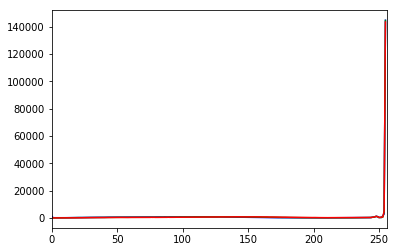

In [35]:
import cv2

cvim = cv2.imread('cat.jpg')

def show_hist(im):
    '''im: Tensor Obejct.'''
    if not type(im) == np.ndarray:
        im = np.transpose(np.asarray(im, dtype=np.uint8), (1,2,0))
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([im], [i], None, [256], [0,256])
        plt.plot(histr, color = col)
        plt.xlim([0,256])
    plt.show()
    
show_hist(cvim)

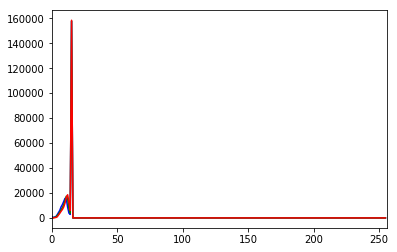

In [39]:
show_hist(np.asarray(cvim**0.5, dtype=np.uint8))

- Magic Transform

In [11]:
def magic_image(im, thrd):
    '''im: PIL Image Object.
    returen: PIL Image Object.'''
    im = np.asarray(im, dtype=np.uint8).copy() # Get own memory
    ir, ic = im.shape[:2]

    im.flags.writeable = True
    for r in range(ir):
        for c in range(ic):
            if np.sum((im[r,c,:] - np.array([255,255,255]))**2) < thrd:
                im[r,c,:] = np.random.rand(3) * 255
            
    return Image.fromarray(im)

In [6]:
import random

def salt_and_pepper(im, n, mode = 'random'):
    # set image to writeable
    im = np.asarray(im, dtype=np.uint8).copy() # Get own memory
    im.flags.writeable = True
    
    for k in range(n):
        i = random.randint(0, im.shape[0] - 1)
        j = random.randint(0, im.shape[1] - 1)
        
        if mode == 'random':
            im[i, j, :] = [255, 255, 255] if random.random() <  0.5 else [0, 0, 0]
        elif mode == 'salt':
            im[i, j, :] = [255, 255, 255]
        elif mode == 'pepper':
            im[i, j, :] = [0, 0, 0]

    # set image to unwriteable
    im.flags.writeable = False
            
    return Image.fromarray(im)

### Image Preprecessing

- Resize

     285 - n02124075  - 0.80 - Egyptian_cat 
     281 - n02123045  - 0.11 - tabby 
     282 - n02123159  - 0.05 - tiger_cat 
     287 - n02127052  - 0.01 - lynx 
     284 - n02123597  - 0.00 - Siamese_cat 


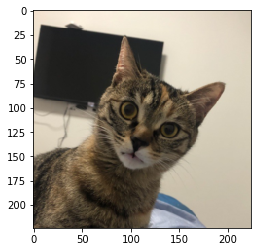

In [7]:
prep = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

x = prep(im)
x = x.unsqueeze(0)

view_data(x[0]*255)

v, idx = [x.detach().numpy()[0] for x in nn.Softmax(dim=1)(model(x)).topk(5)]
for prob, pred in zip(v,idx):
    Id, n = labels[str(pred)]
    print(f'{pred:8} - {Id:10} - {prob:.2f} - {n} ')
    

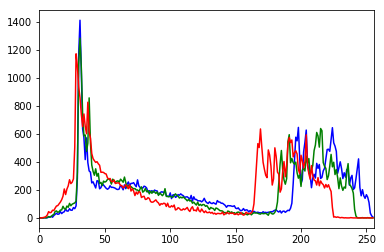

In [8]:
show_hist(x[0]*255)

- CenterCrop

     281 - n02123045  - 0.40 - tabby 
     285 - n02124075  - 0.22 - Egyptian_cat 
     282 - n02123159  - 0.19 - tiger_cat 
     283 - n02123394  - 0.06 - Persian_cat 
     284 - n02123597  - 0.02 - Siamese_cat 


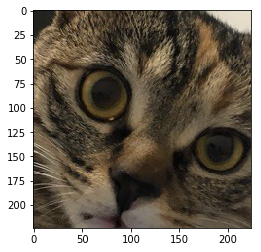

In [9]:
prep = transforms.Compose([
    transforms.CenterCrop((224,224)),
    transforms.ToTensor()
])

x = prep(im)
x = x.unsqueeze(0)

view_data(x[0]*255)

v, idx = [x.detach().numpy()[0] for x in nn.Softmax(dim=1)(model(x)).topk(5)]
for prob, pred in zip(v,idx):
    Id, n = labels[str(pred)]
    print(f'{pred:8} - {Id:10} - {prob:.2f} - {n} ')

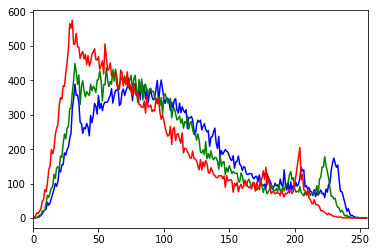

In [32]:
show_hist(x[0]*255)

- ColorJit and Resize

     728 - n03958227  - 0.28 - plastic_bag 
     285 - n02124075  - 0.09 - Egyptian_cat 
     457 - n02883205  - 0.05 - bow_tie 
     725 - n03950228  - 0.02 - pitcher 
     968 - n07930864  - 0.02 - cup 


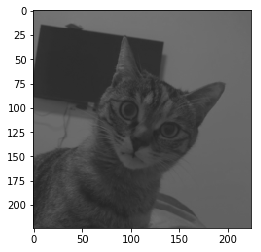

In [92]:
prep = transforms.Compose([
    transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
    transforms.Grayscale(3),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

x = prep(im)
x = x.unsqueeze(0)

view_data(x[0]*255)

v, idx = [x.detach().numpy()[0] for x in nn.Softmax(dim=1)(model(x)).topk(5)]
for prob, pred in zip(v,idx):
    Id, n = labels[str(pred)]
    print(f'{pred:8} - {Id:10} - {prob:.2f} - {n} ')


- FiveCrop

---------------------------
     662 - n03777754  - 0.06 - modem 
     499 - n03041632  - 0.05 - cleaver 
     620 - n03642806  - 0.04 - laptop 
     681 - n03832673  - 0.04 - notebook 
     446 - n02840245  - 0.03 - binder 
---------------------------
---------------------------
     674 - n03794056  - 0.03 - mousetrap 
     604 - n03544143  - 0.02 - hourglass 
     298 - n02137549  - 0.01 - mongoose 
     103 - n01873310  - 0.01 - platypus 
     596 - n03498962  - 0.01 - hatchet 
---------------------------
---------------------------
     296 - n02134084  - 0.11 - ice_bear 
     338 - n02364673  - 0.10 - guinea_pig 
     279 - n02120079  - 0.04 - Arctic_fox 
     977 - n09421951  - 0.03 - sandbar 
     223 - n02104365  - 0.03 - schipperke 
---------------------------
---------------------------
     906 - n04591157  - 0.04 - Windsor_tie 
     749 - n04033901  - 0.04 - quill 
     284 - n02123597  - 0.04 - Siamese_cat 
     728 - n03958227  - 0.02 - plastic_bag 
     356 - n02441942 

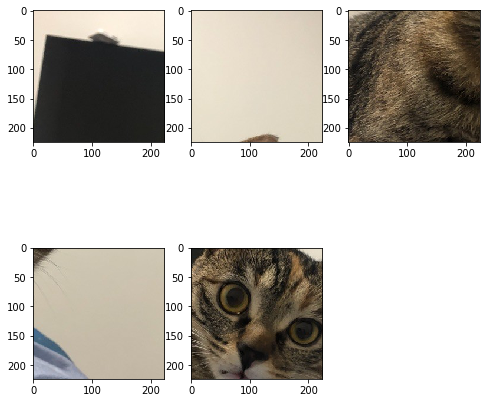

In [81]:
prep = transforms.Compose([
    transforms.FiveCrop((224,224)),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops]))
])

x = prep(im)
#x = x.unsqueeze(0)

entries = [[x.detach().numpy()[i] for x in nn.Softmax(dim=1)(model(x)).topk(5)] for i in range(x.shape[0])]
for v, idx in entries:
    print('---------------------------')
    for prob, pred in zip(v,idx):
        Id, n = labels[str(pred)]
        print(f'{pred:8} - {Id:10} - {prob:.2f} - {n} ')
    print('---------------------------')
    
# Multiple Image Display
fig=plt.figure(figsize=(8, 8))
for i in range(1, 6):
    fig.add_subplot(2, 3, i)
    plt.imshow(np.transpose(np.asarray(x[i-1]*255, dtype=np.uint8), (1,2,0)))
plt.show()

- Grayscale

     285 - n02124075  - 0.83 - Egyptian_cat 
     281 - n02123045  - 0.09 - tabby 
     282 - n02123159  - 0.03 - tiger_cat 
     287 - n02127052  - 0.01 - lynx 
     284 - n02123597  - 0.01 - Siamese_cat 


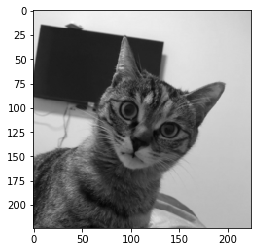

In [82]:
prep = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

x = prep(im)
x = x.unsqueeze(0)

view_data(x[0]*255)

v, idx = [x.detach().numpy()[0] for x in nn.Softmax(dim=1)(model(x)).topk(5)]
for prob, pred in zip(v,idx):
    Id, n = labels[str(pred)]
    print(f'{pred:8} - {Id:10} - {prob:.2f} - {n} ')

- Pad

     285 - n02124075  - 0.70 - Egyptian_cat 
     281 - n02123045  - 0.15 - tabby 
     282 - n02123159  - 0.06 - tiger_cat 
     287 - n02127052  - 0.04 - lynx 
     728 - n03958227  - 0.01 - plastic_bag 


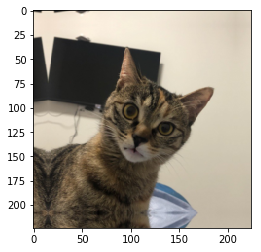

In [97]:
prep = transforms.Compose([
    transforms.Pad(padding=50, fill=0, padding_mode='reflect'),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

x = prep(im)
x = x.unsqueeze(0)

view_data(x[0]*255)

v, idx = [x.detach().numpy()[0] for x in nn.Softmax(dim=1)(model(x)).topk(5)]
for prob, pred in zip(v,idx):
    Id, n = labels[str(pred)]
    print(f'{pred:8} - {Id:10} - {prob:.2f} - {n} ')

- RandomAffine

283 - n02123394  - 0.10 - Persian_cat 
728 - n03958227  - 0.09 - plastic_bag 
281 - n02123045  - 0.09 - tabby 
285 - n02124075  - 0.09 - Egyptian_cat 
552 - n03325584  - 0.03 - feather_boa 


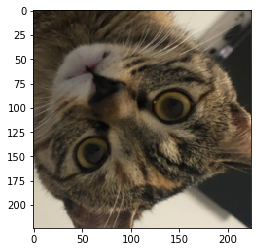

In [147]:
prep = transforms.Compose([
    transforms.RandomAffine(degrees=random.randrange(0,180), translate=None,
                            scale=(1,2), 
                            shear=random.randrange(0,30), resample=False, fillcolor=0),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

x = prep(im)
x = x.unsqueeze(0)

view_data(x[0]*255)

v, idx = [x.detach().numpy()[0] for x in nn.Softmax(dim=1)(model(x)).topk(5)]
for prob, pred in zip(v,idx):
    Id, n = labels[str(pred)]
    print(f'{pred:3} - {Id:10} - {prob:.2f} - {n} ')


- flip

285 - n02124075  - 0.38 - Egyptian_cat 
728 - n03958227  - 0.17 - plastic_bag 
281 - n02123045  - 0.09 - tabby 
282 - n02123159  - 0.05 - tiger_cat 
272 - n02114855  - 0.04 - coyote 


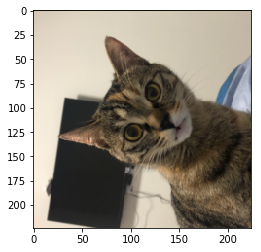

In [159]:
prep = transforms.Compose([
    transforms.RandomAffine(degrees=(270,270)),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

x = prep(im)
x = x.unsqueeze(0)

view_data(x[0]*255)

v, idx = [x.detach().numpy()[0] for x in nn.Softmax(dim=1)(model(x)).topk(5)]
for prob, pred in zip(v,idx):
    Id, n = labels[str(pred)]
    print(f'{pred:3} - {Id:10} - {prob:.2f} - {n} ')


### Magic Transformation

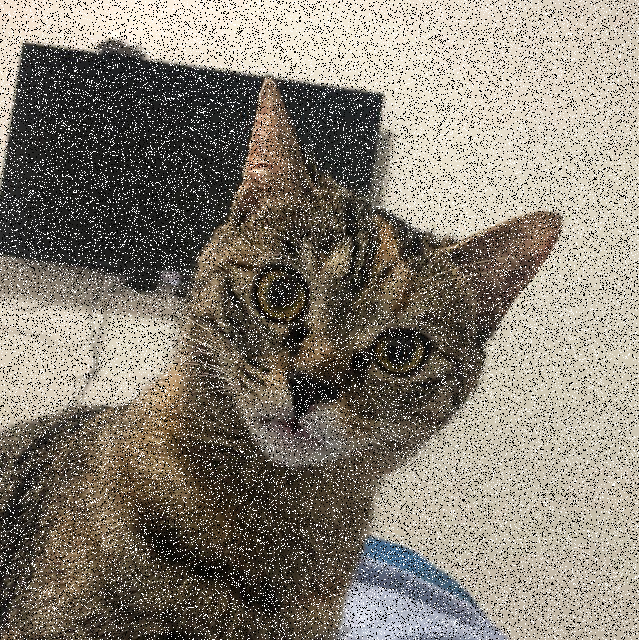

In [28]:
#mim = magic_image(im, 2e4)
mim = salt_and_pepper(im, 300*300)
mim

- Resize

     285 - n02124075  - 0.22 - Egyptian_cat 
     281 - n02123045  - 0.13 - tabby 
     620 - n03642806  - 0.07 - laptop 
     287 - n02127052  - 0.04 - lynx 
     282 - n02123159  - 0.04 - tiger_cat 


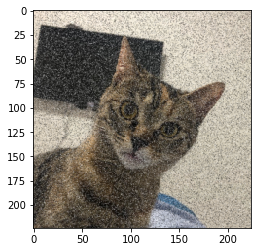

In [29]:
prep = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

x = prep(mim)
x = x.unsqueeze(0)

view_data(x[0]*255)

v, idx = [x.detach().numpy()[0] for x in nn.Softmax(dim=1)(model(x)).topk(5)]
for prob, pred in zip(v,idx):
    Id, n = labels[str(pred)]
    print(f'{pred:8} - {Id:10} - {prob:.2f} - {n} ')

- CenterCrop

     794 - n04209239  - 0.11 - shower_curtain 
     562 - n03388043  - 0.08 - fountain 
     974 - n09288635  - 0.05 - geyser 
     885 - n04525038  - 0.04 - velvet 
     977 - n09421951  - 0.03 - sandbar 


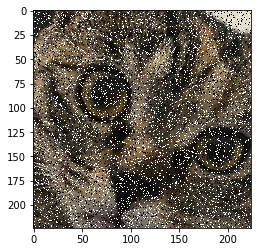

In [30]:
prep = transforms.Compose([
    transforms.CenterCrop((224,224)),
    transforms.ToTensor()
])

x = prep(mim)
x = x.unsqueeze(0)

view_data(x[0]*255)

v, idx = [x.detach().numpy()[0] for x in nn.Softmax(dim=1)(model(x)).topk(5)]
for prob, pred in zip(v,idx):
    Id, n = labels[str(pred)]
    print(f'{pred:8} - {Id:10} - {prob:.2f} - {n} ')

     911 - n04599235  - 0.12 - wool 
     539 - n03223299  - 0.07 - doormat 
      69 - n01768244  - 0.04 - trilobite 
     591 - n03485794  - 0.03 - handkerchief 
     816 - n04277352  - 0.03 - spindle 


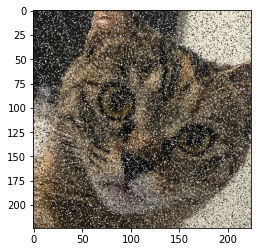

In [31]:
prep = transforms.Compose([
    transforms.CenterCrop((333,333)),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

x = prep(mim)
x = x.unsqueeze(0)

view_data(x[0]*255)

v, idx = [x.detach().numpy()[0] for x in nn.Softmax(dim=1)(model(x)).topk(5)]
for prob, pred in zip(v,idx):
    Id, n = labels[str(pred)]
    print(f'{pred:8} - {Id:10} - {prob:.2f} - {n} ')